In [1]:
import pandas as pd
import numpy as np
import torch 
from tqdm import tqdm 
import os 
import json
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import torch
import recmetrics
d = torch.device('cuda:6')
dataroot = os.path.join(".","data")

## Splite training and testing data

testing school year: 499*

### User Course

In [ ]:
user_course_dense = pd.read_csv(
    os.path.join(dataroot,"course","usercoursedense.csv"),
    encoding='utf-8'
)
user_course_dense['uid'] = user_course_dense['uid'].astype(str)
user_course_dense.head()

In [4]:
user_course_dense.shape


(21829, 7055)

In [ ]:
user_course_test = user_course_dense[
    user_course_dense.uid.str.startswith('499')
]
user_course_test.head()

In [6]:
user_course_test.shape

(1254, 7055)

In [ ]:
user_course_train = user_course_dense[
    ~user_course_dense.uid.str.startswith('499')
]
user_course_train.head()

In [8]:
user_course_train.shape

(20575, 7055)

In [9]:
user_course_train.to_csv(
    os.path.join(dataroot, "course","train.csv"),
    index = False
)
user_course_test.to_csv(
    os.path.join(dataroot, "course", "test.csv"),
    index = False
)

### Book User

In [ ]:
book_user = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_userdense.csv")
)
book_user.head()

In [24]:
test_students = list(x for x in list(book_user.columns) if x[:3]=="499")
print(len(test_students))

1254


In [ ]:
book_user_test = book_user[test_students]
book_user_test.head()

In [ ]:
train_students = list(x for x in list(book_user.columns) if x[:3]!="499")
book_user_train = book_user[train_students ]
book_user_train.head()

In [30]:
book_user_train.to_csv(
    os.path.join(dataroot, "book", "cate3_train.csv"),
    index = False
)
book_user_test.to_csv(
    os.path.join(dataroot, "book", "cate3_test.csv"),
    index = False
)

#### Number of lending record for each student

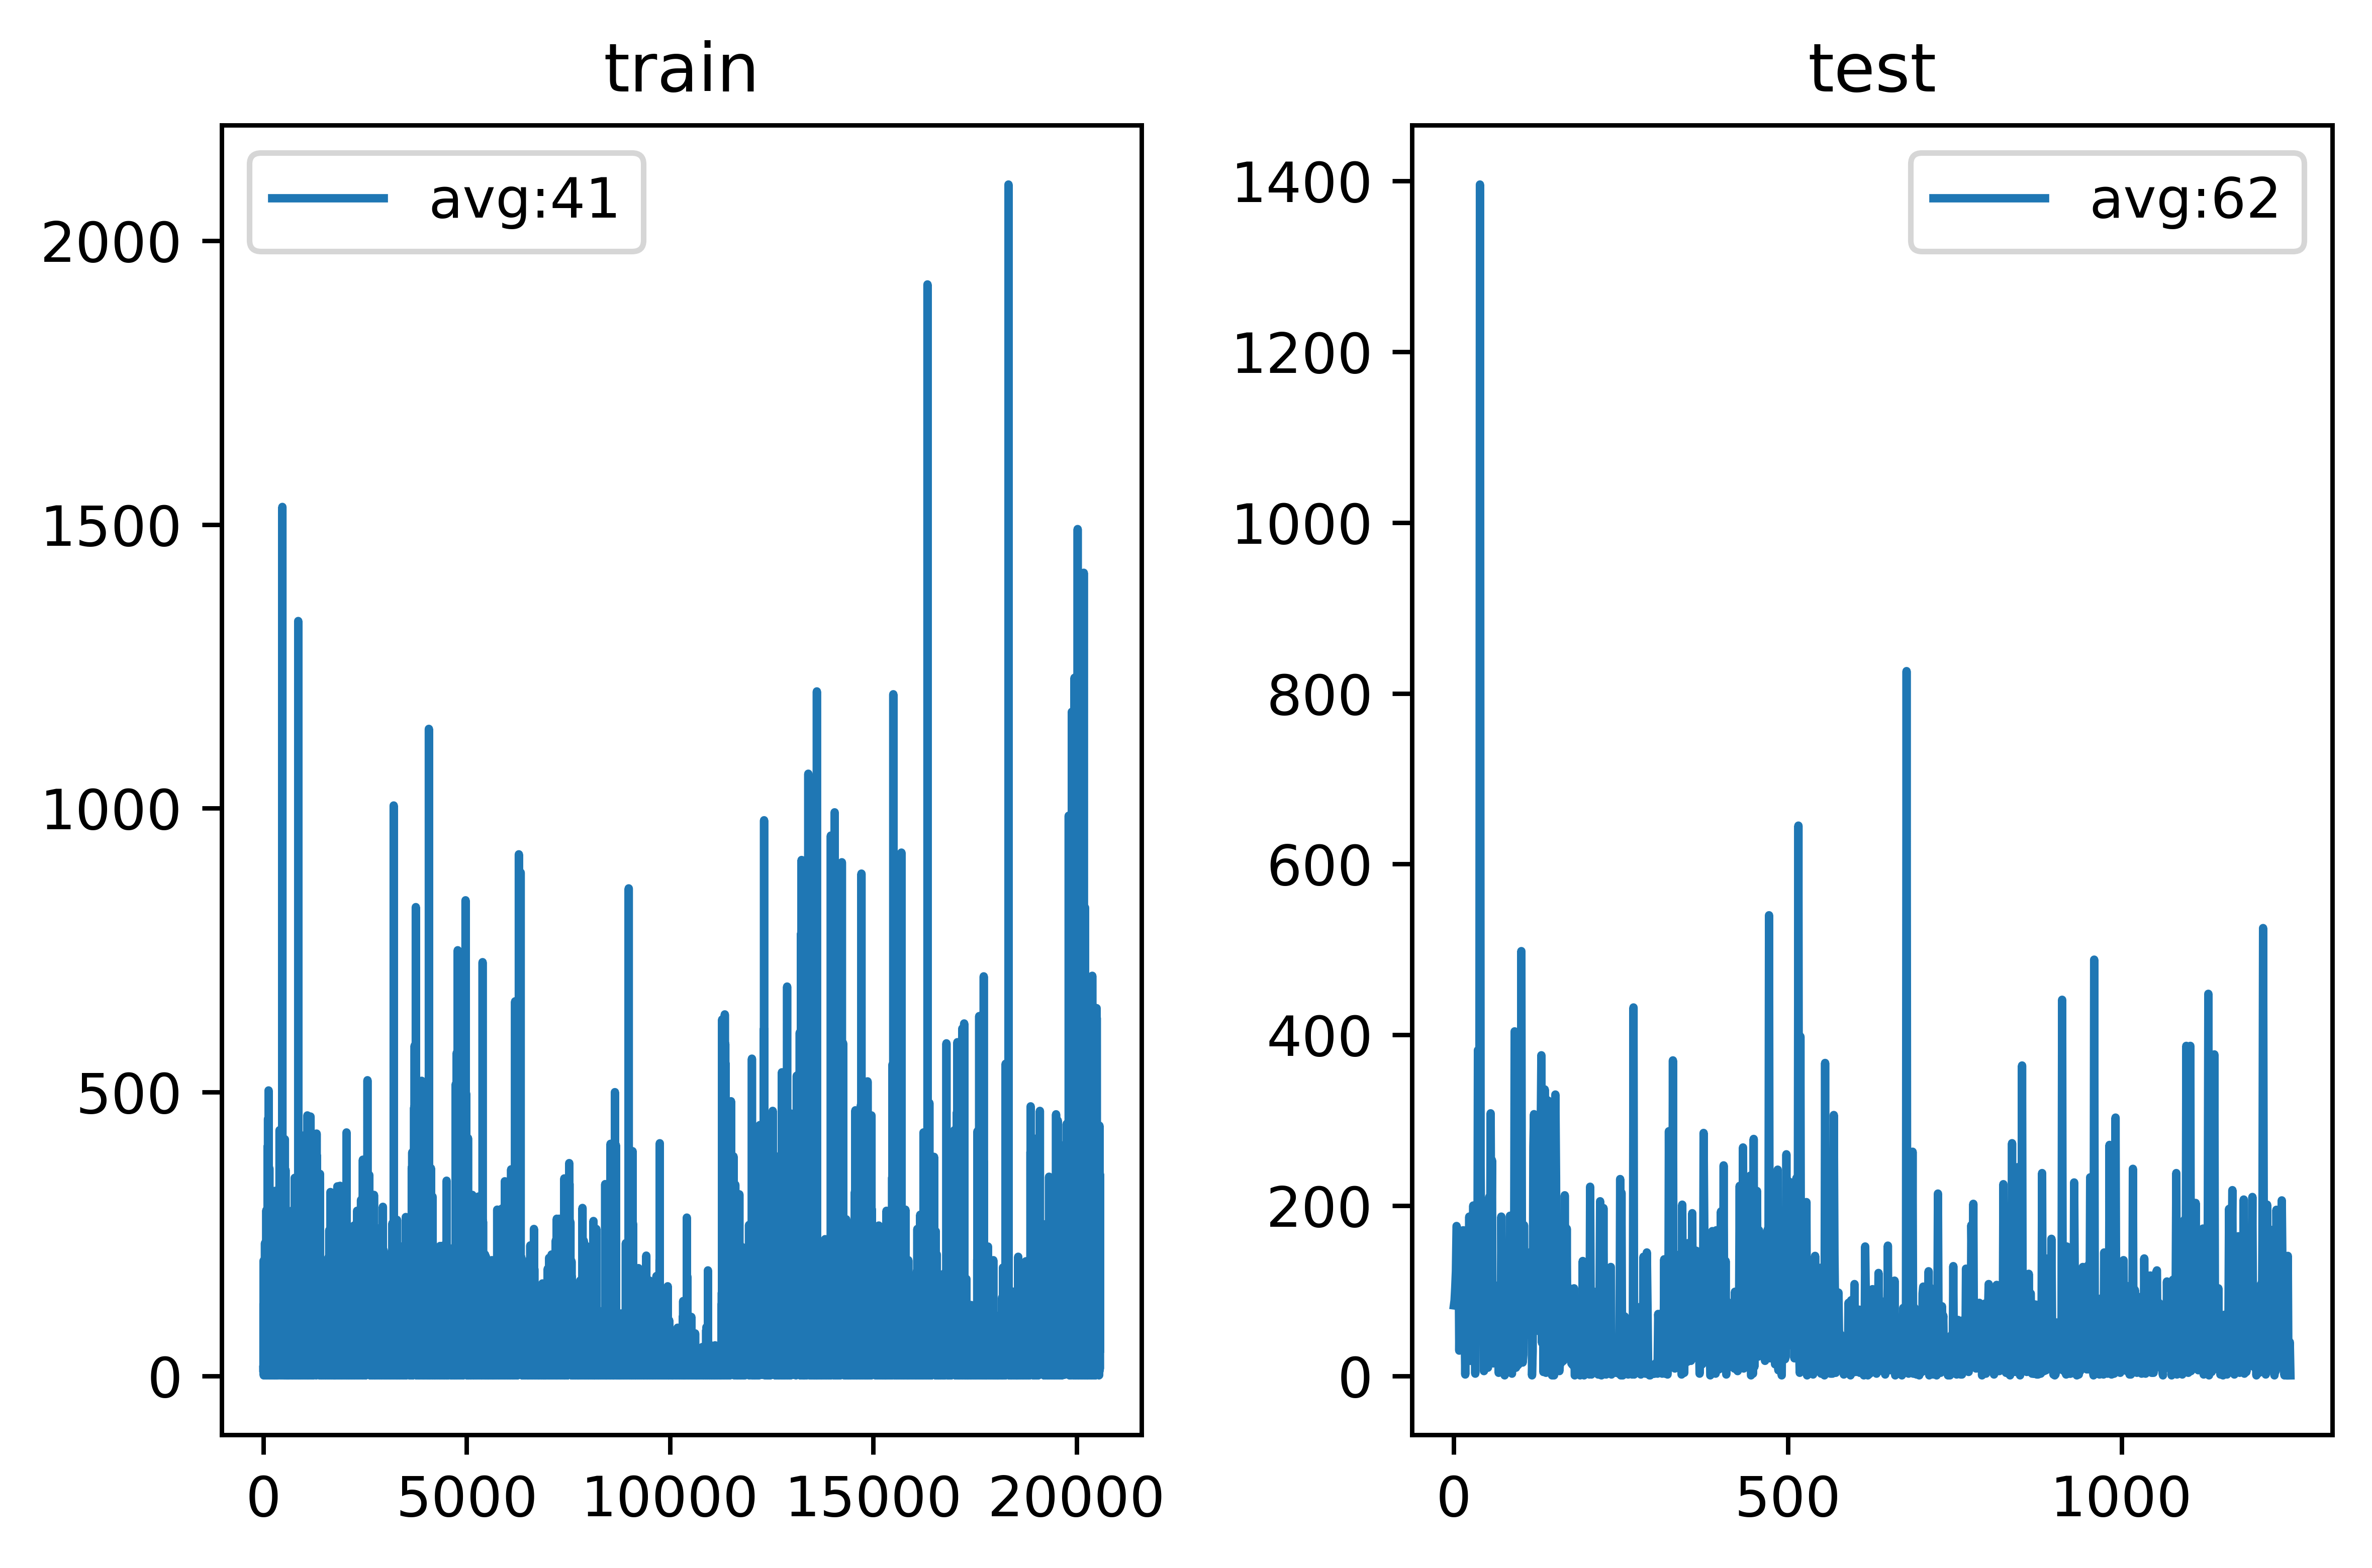

In [67]:
train_des = np.sum(book_user_train.values,axis = 0 )
test_des = np.sum(book_user_test.values, axis = 0)

fig = plt.figure(dpi=800)
plt.subplot(121)
plt.plot(
    list(i for i in range(book_user_train.shape[1])), 
    train_des, label=f"avg:{np.mean(train_des):.0f}"
)
plt.legend()
plt.title("train")

plt.subplot(122)
plt.plot(
    list(i for i in range(book_user_test.shape[1])), 
    test_des,label=f"avg:{np.mean(test_des):.0f}"
)
plt.legend()
plt.title("test")

plt.tight_layout()
plt.savefig(os.path.join(dataroot,"book","train_test_count.jpg"))


## Recommend

### Construct CF matrix
 
$$M_{\text{book}\times\text{train users}} \times M_{\text{train users}\times\text{course}}$$

In [ ]:
user_course_train = pd.read_csv(
    os.path.join(dataroot, "course","train.csv")
)
user_course_train['uid'] = user_course_train['uid'].astype(str)
print("train user course OK")


book_user_train = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_train.csv")
)
print("train book user Ok")

In [224]:
book_user_train_tensor = torch.tensor(
    book_user_train.values
)
print(book_user_train_tensor.size())

user_course_train_tensor = torch.tensor(
    (user_course_train.drop(columns=['uid'])).values
)
print(user_course_train_tensor.size())



torch.Size([1000, 20575])
torch.Size([20575, 7054])


In [227]:
book_course_tensor = torch.matmul(
    book_user_train_tensor.to(device=d),
    user_course_train_tensor.to(device=d)
).cpu()

print(book_course_tensor.size())


torch.Size([1000, 7054])


##### Write result for 3 type of file
torch tensor, numpy array, csv

In [233]:
torch.save(
    book_course_tensor, 
    os.path.join("result","CF","cf_book_course.pt")
)

In [228]:
book_course_matrix = book_course_tensor.numpy()

In [229]:
np.save(
    os.path.join("result","CF","cf_book_course"),
    book_course_matrix
)

In [ ]:
book_course_df = pd.DataFrame(
    columns=user_course_train.drop(columns=['uid']).columns,
    data=book_course_matrix
)
print(book_course_df.shape)
book_course_df.head()

In [10]:
book_course_df.to_csv(
    os.path.join("result","CF","cf_book_course.csv"),
    index = False
)

### Using naive CF

In [3]:
user_course_test = pd.read_csv(
    os.path.join(dataroot, "course", "test.csv")
)
user_course_test['uid'] = user_course_test['uid'].astype(str)
print("test user course OK")

user_course_test_matrix = (
    user_course_test.drop(columns = ['uid'])
).values



test user course OK


#### Read the collaborative tabel 
$M_{\text{book}\times \text{course}}$

In [3]:
# If continuous executing this Note book from 
# the H1 label "Recommend"
# ,there is no needed to execute this cell

book_course_tensor= torch.load(
    os.path.join("result","CF","cf_book_course.pt")
)
book_course_tensor.size()

torch.Size([1000, 7054])

#### Collaborative filter to generate personal recommend list
Find the top N number of each prefix 3 book categories that counted from the other studensts who have had the same courses with the test student.

In [6]:
recommend_list = {}
for i in tqdm(range(user_course_test.shape[0])):
    uid = user_course_test.iloc[i]['uid']
    testi = user_course_test_matrix[i][:]
    itscourses = np.where(testi>0)
    cf = torch.sum(book_course_tensor[:, itscourses[0]],dim=1)
    ordered = torch.argsort(cf,descending=True)
    recommend_list[uid] = ordered.tolist()

100%|██████████| 1254/1254 [00:05<00:00, 218.42it/s]


In [7]:
with open(os.path.join("result","CF","recommend_list.json"),"w+") as rl:
    json.dump(recommend_list, rl, indent=4)


### Evaluation (Precision Recall)

In [2]:
from evaluationTool import Evaluator, VisualizationKit

In [10]:
book_user_test = pd.read_csv(
    os.path.join(dataroot, "book", "cate3_test.csv")
)
print("test book user Ok")


test book user Ok


In [176]:
recommend_list = {}

with open(os.path.join("result", "CF", "recommend_list.json"),"r") as jf:
    recommend_list = json.load(jf)


In [177]:
eva = Evaluator(
    recommend_list=recommend_list, testing_ans=book_user_test
)

#### Origin result

##### Not calculation yet

In [ ]:
cmp_diff_n = eva.different_topN(max_topN=1000, rule_table=None)

In [ ]:
with open(os.path.join("result", "CF","metrics","metrics.json"), "w+") as log:
    json.dump(cmp_diff_n, log, indent=4, ensure_ascii=False)

##### If Using ```calpr.py``` pre-calculation

In [3]:
cmp_diff_n = {}
with open(os.path.join("result", "CF","metrics","metrics.json"), "r") as log:
    cmp_diff_n = json.load(log)

##### Vis

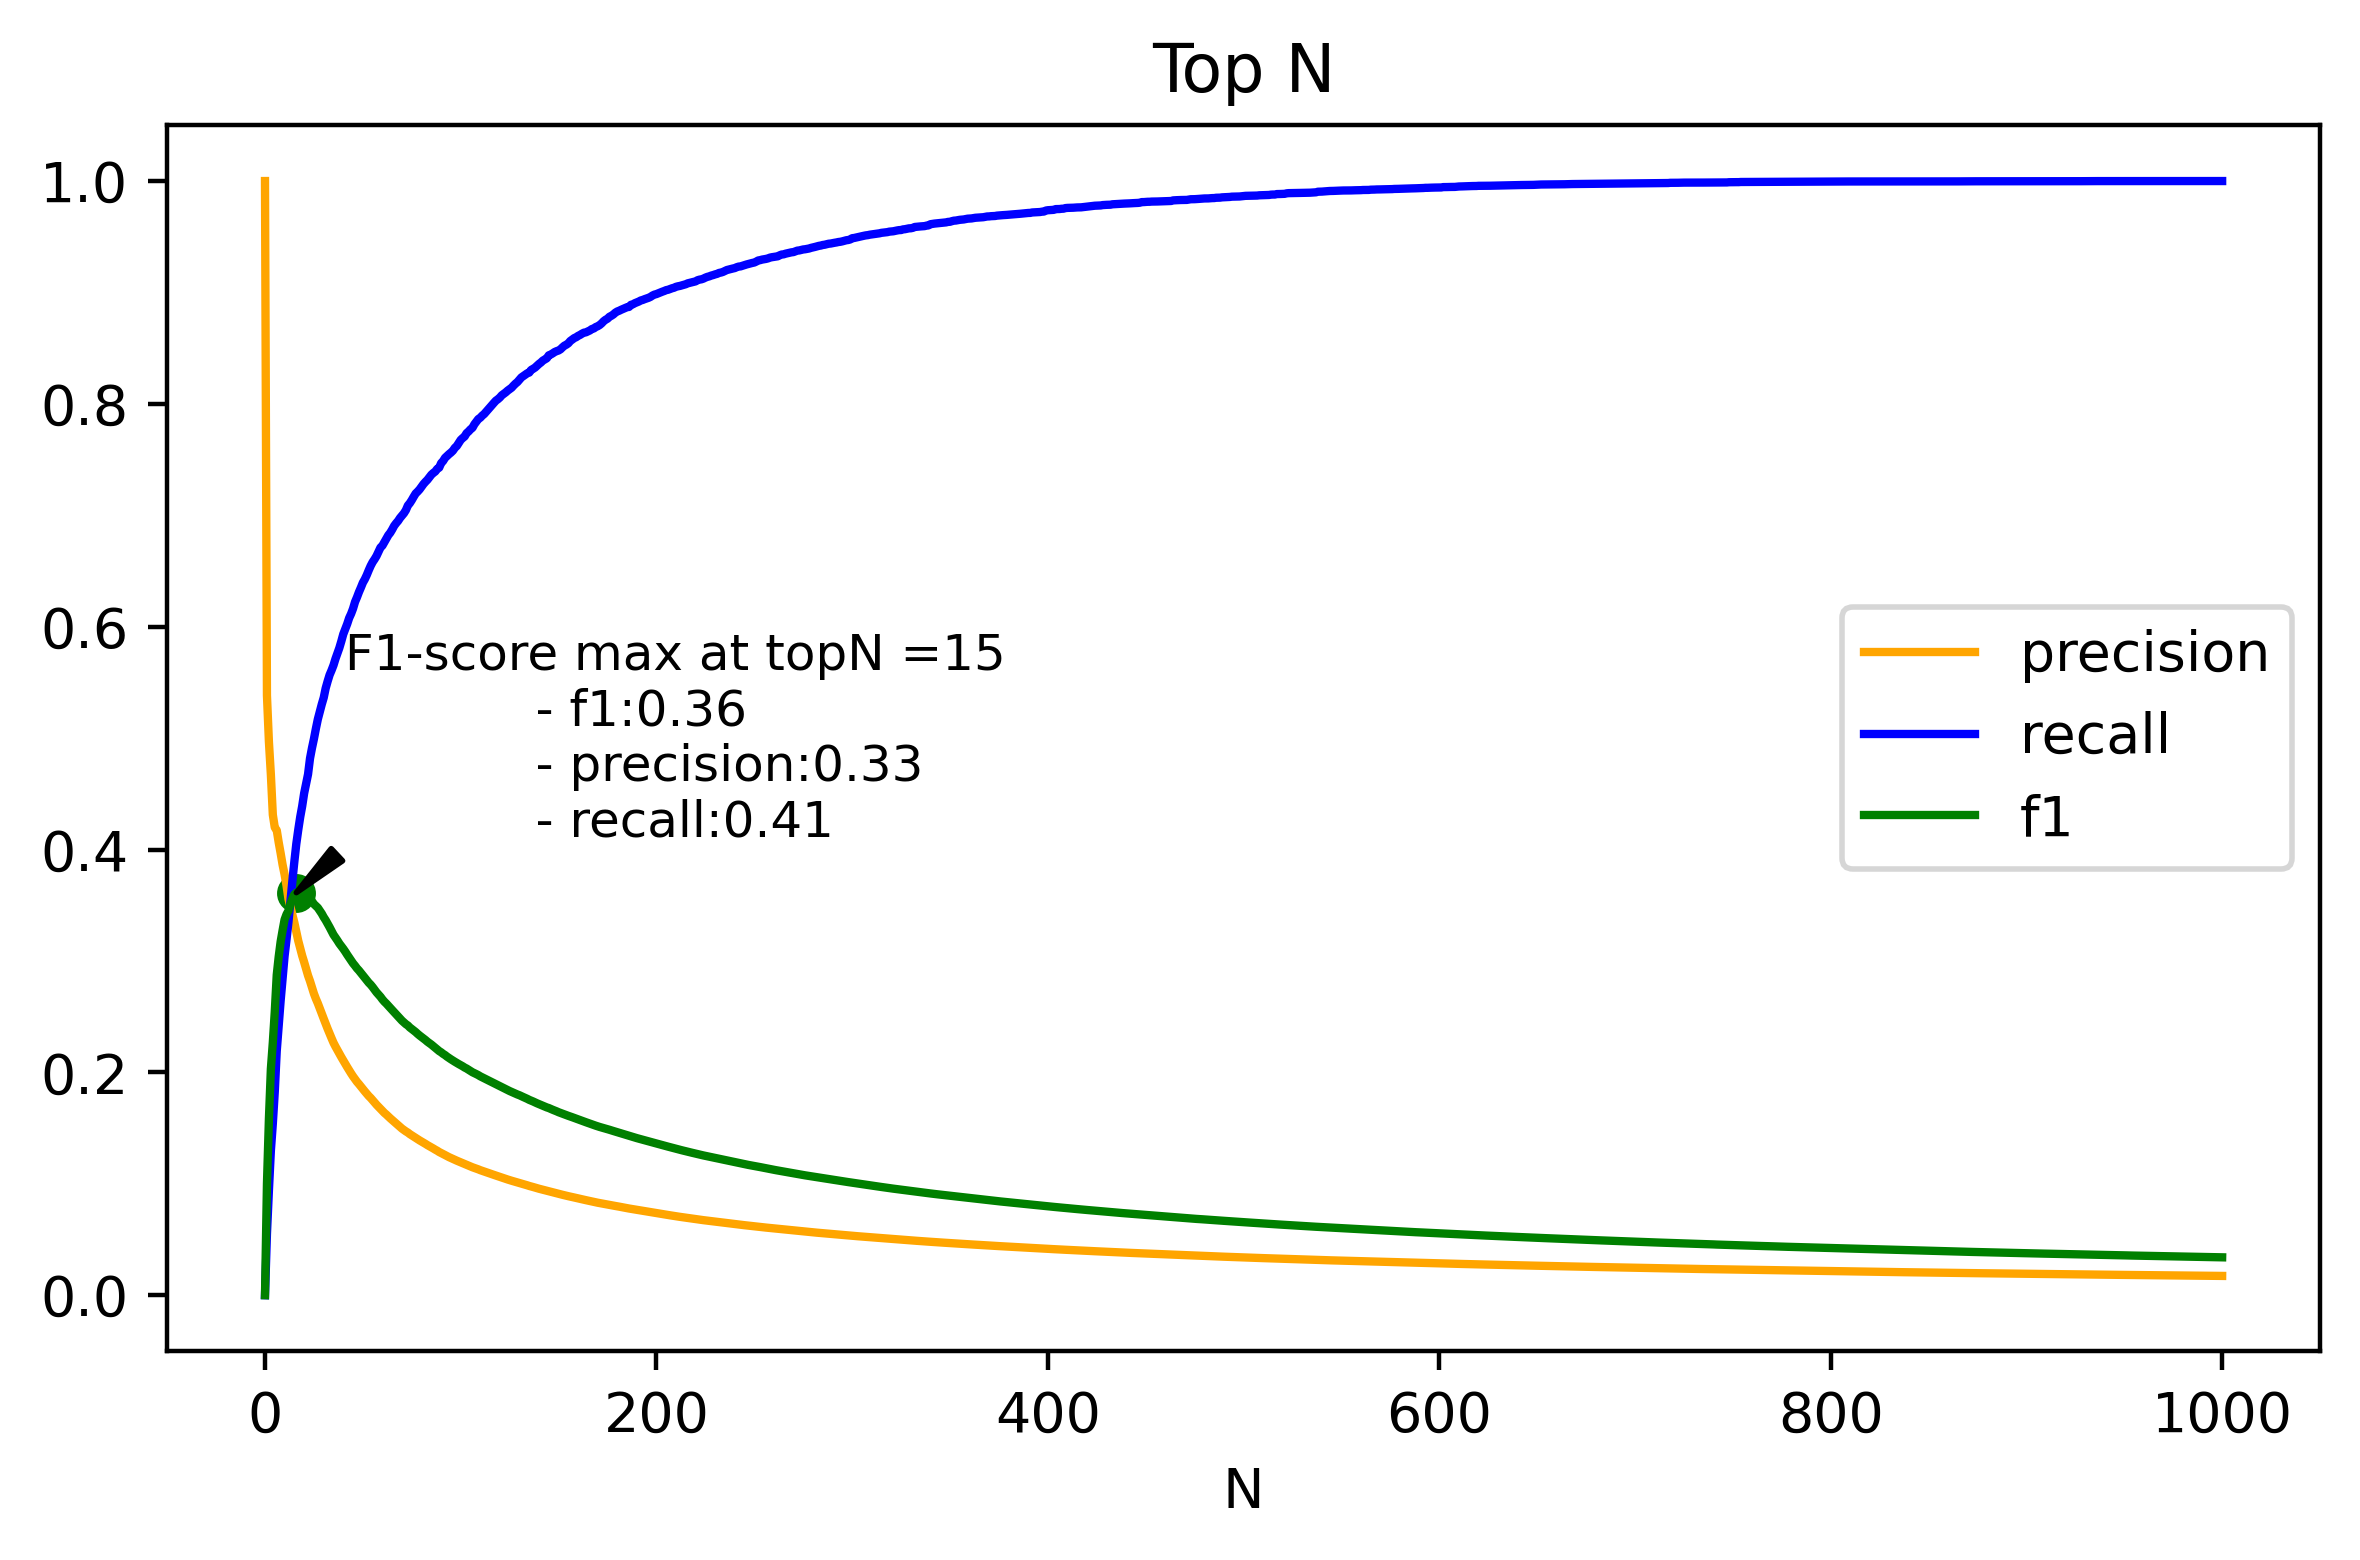

In [4]:
VisualizationKit.plot_cmp_different_n(
    prec=cmp_diff_n['precision'],
    recall=cmp_diff_n['recall'],
    f1=cmp_diff_n['f1']['val'],
    f1maxpos=cmp_diff_n['f1']['maxpos'],
    max_topN=1000,
    savepath=os.path.join("result","CF", "metrics","metrics.jpg")
)

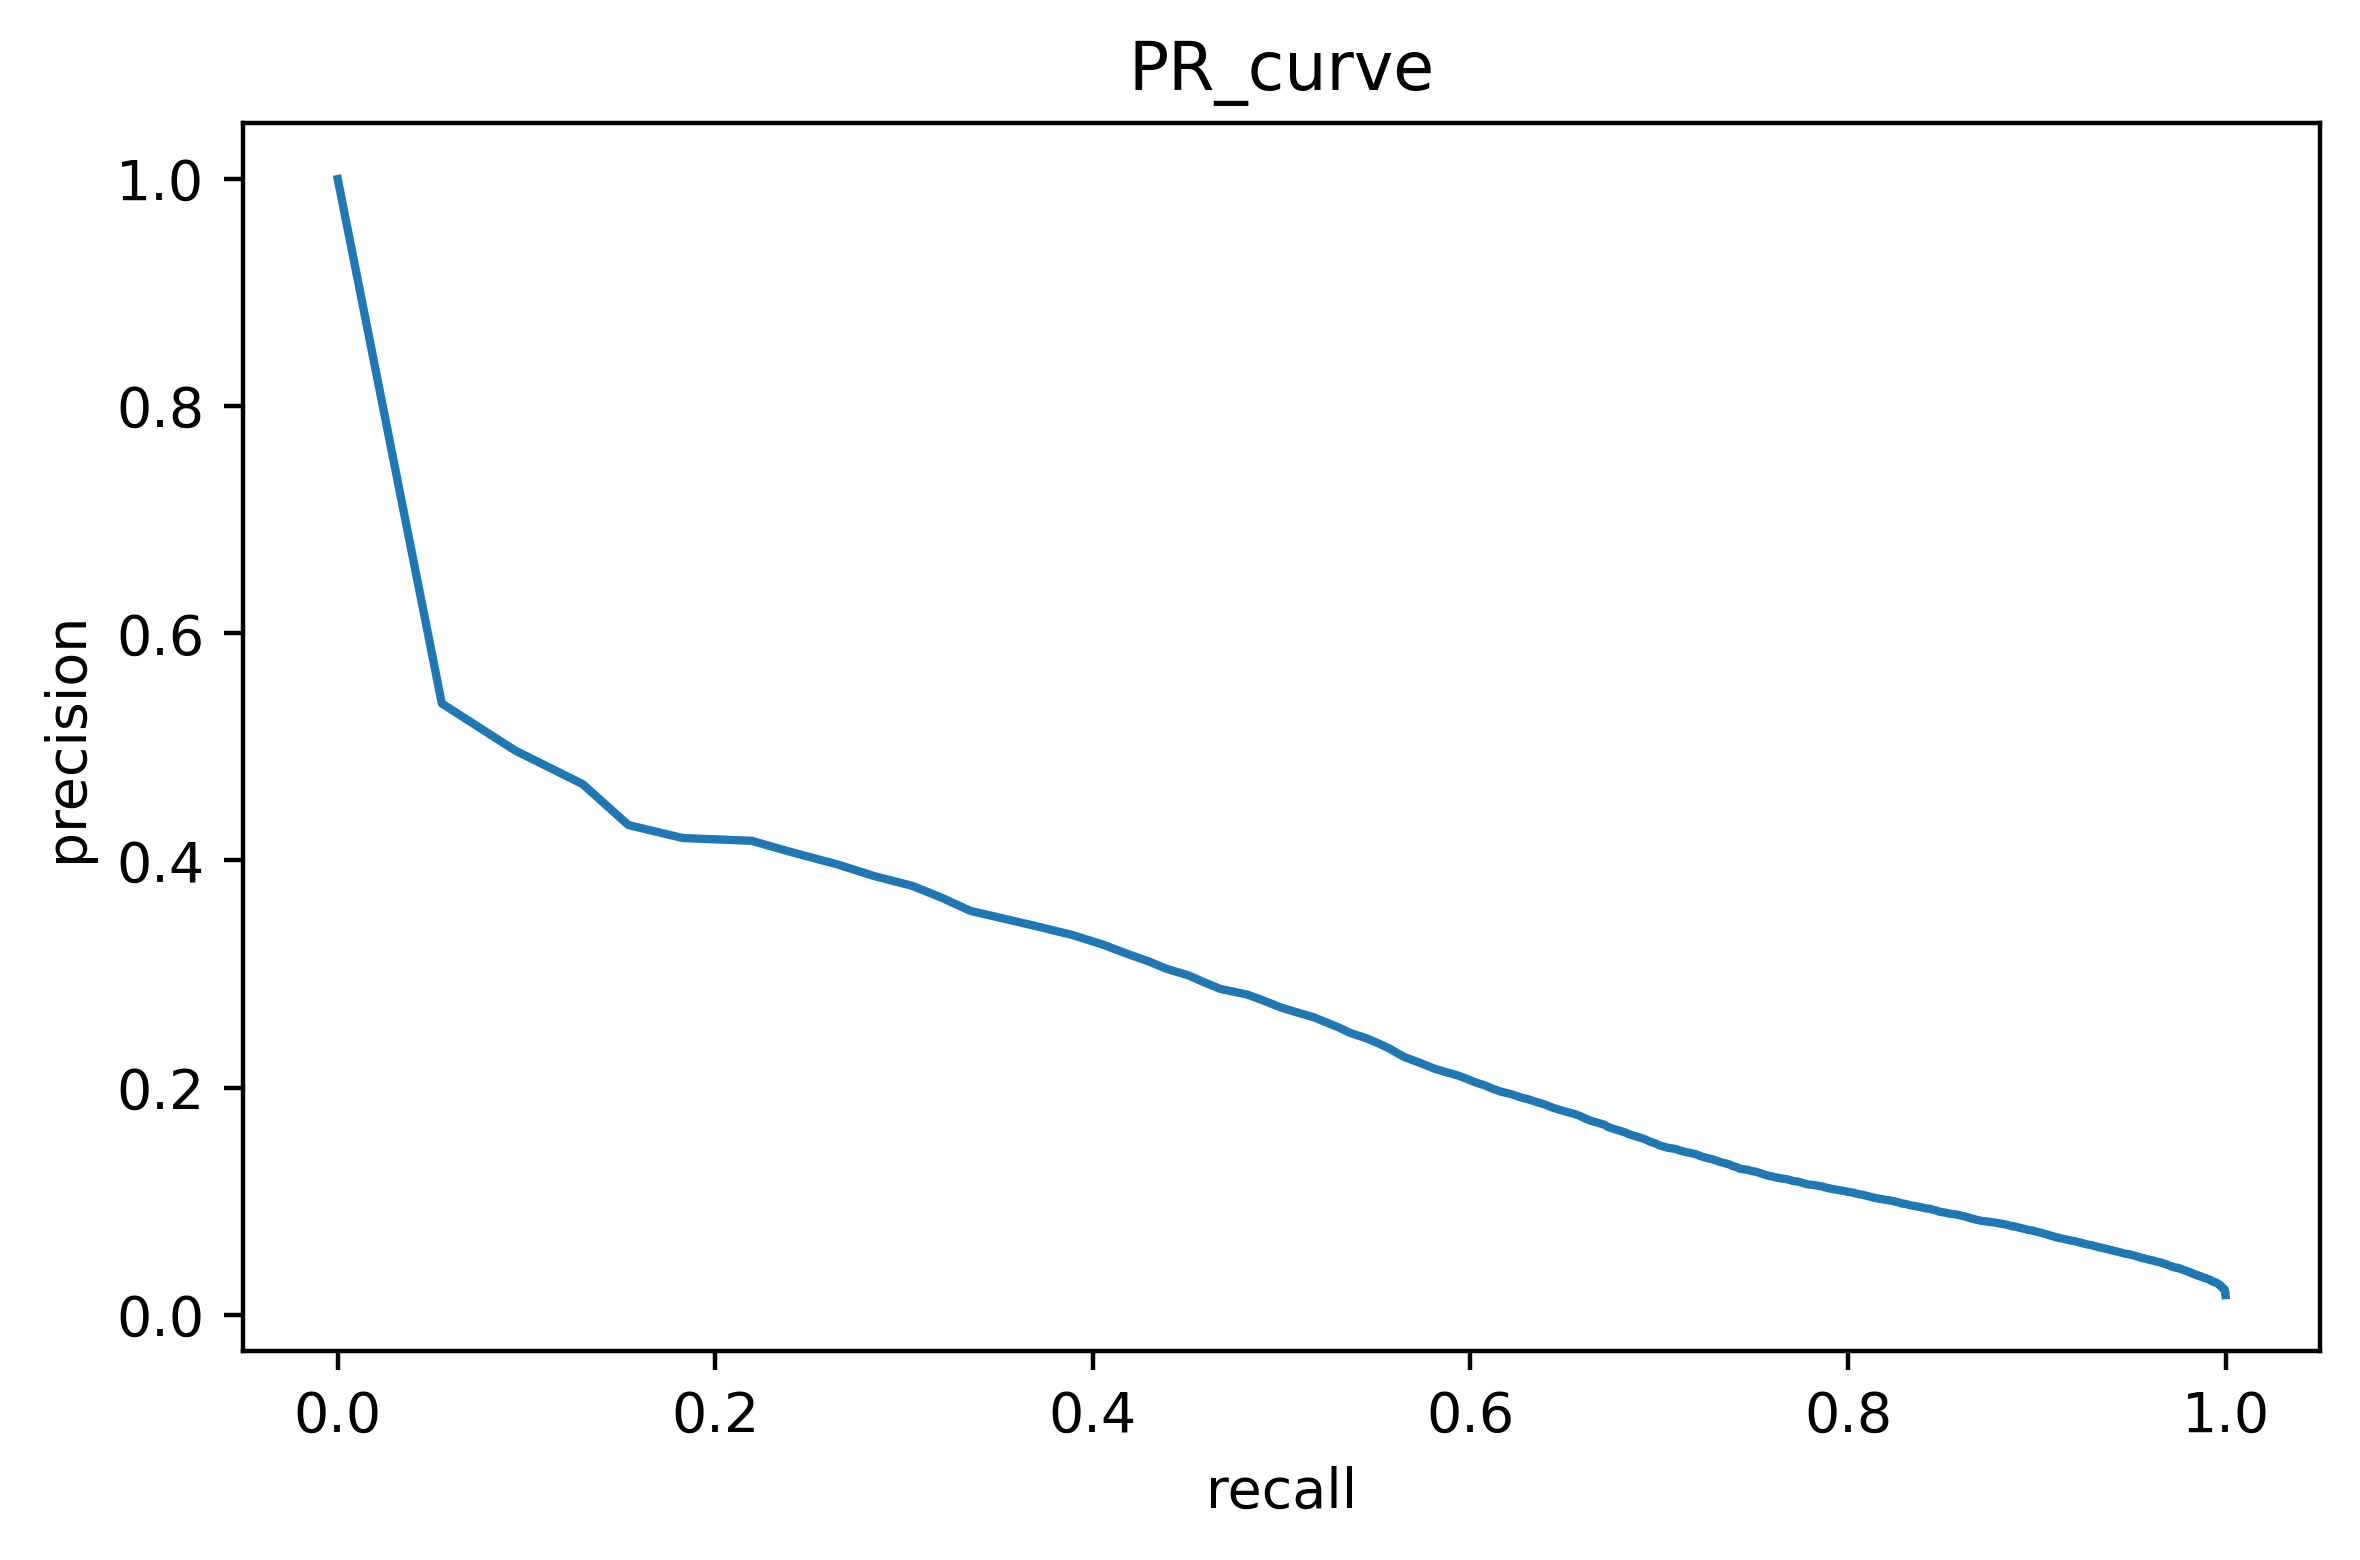

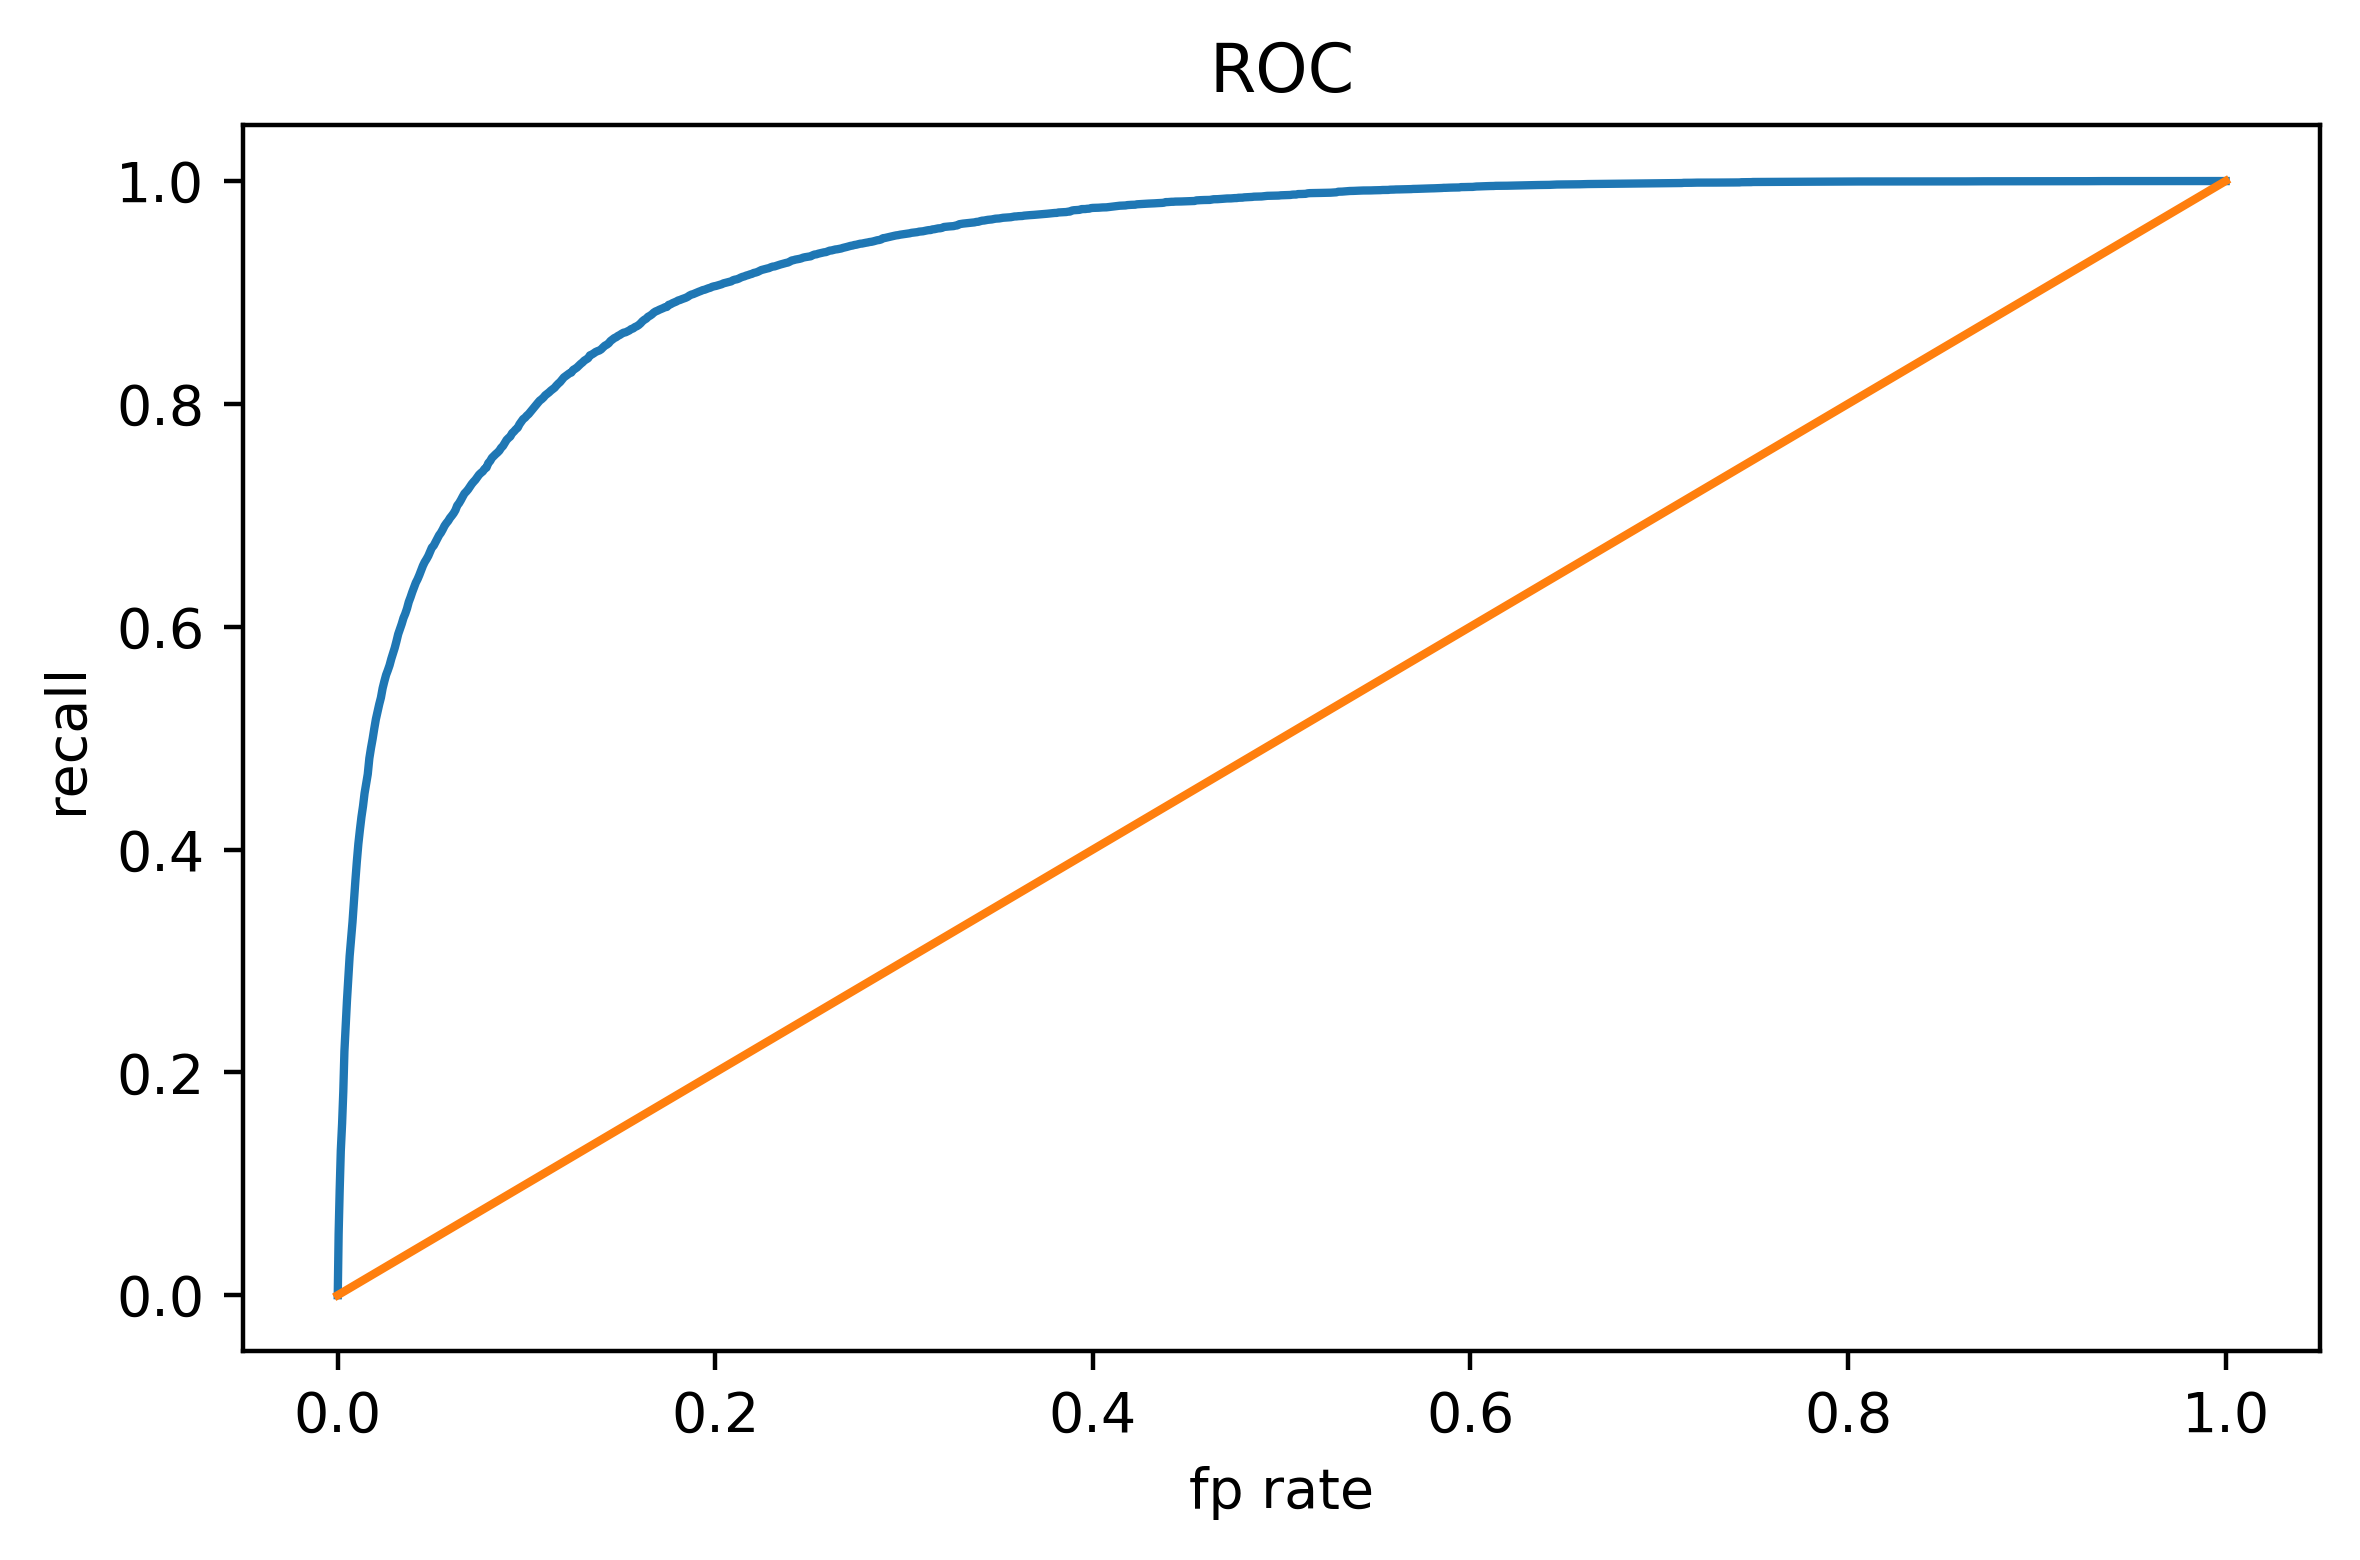

In [6]:
VisualizationKit.ROC(
    cmp_diff_n['fpr'], cmp_diff_n['recall'],
    savepath=os.path.join("result","CF", "metrics","ROC.jpg")
)

#### adding association rule result Evaluation (Precision Recall)

In [56]:
rule_table=np.zeros((1000, 1000), dtype=int)
rules = []
with open(os.path.join("result", "association", "layer3", "all.txt"), "r") as rulefile:
    r = rulefile.readlines()
    for idx, line in enumerate(r):
        lines = line.strip().split(" ")
        tmp = list(int(i.strip()) for i in lines)
        if len(tmp) > 1:
            rules.append(tmp)
for ri in tqdm(rules):
    for rii in ri:
        for rij in ri:
            rule_table[rii][rij] = 1
            rule_table[rij][rii] = 1

100%|██████████| 37/37 [00:00<00:00, 100706.84it/s]


In [57]:
normalization = eva.different_topN(
    max_topN=100, rule_table=rule_table
)

100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


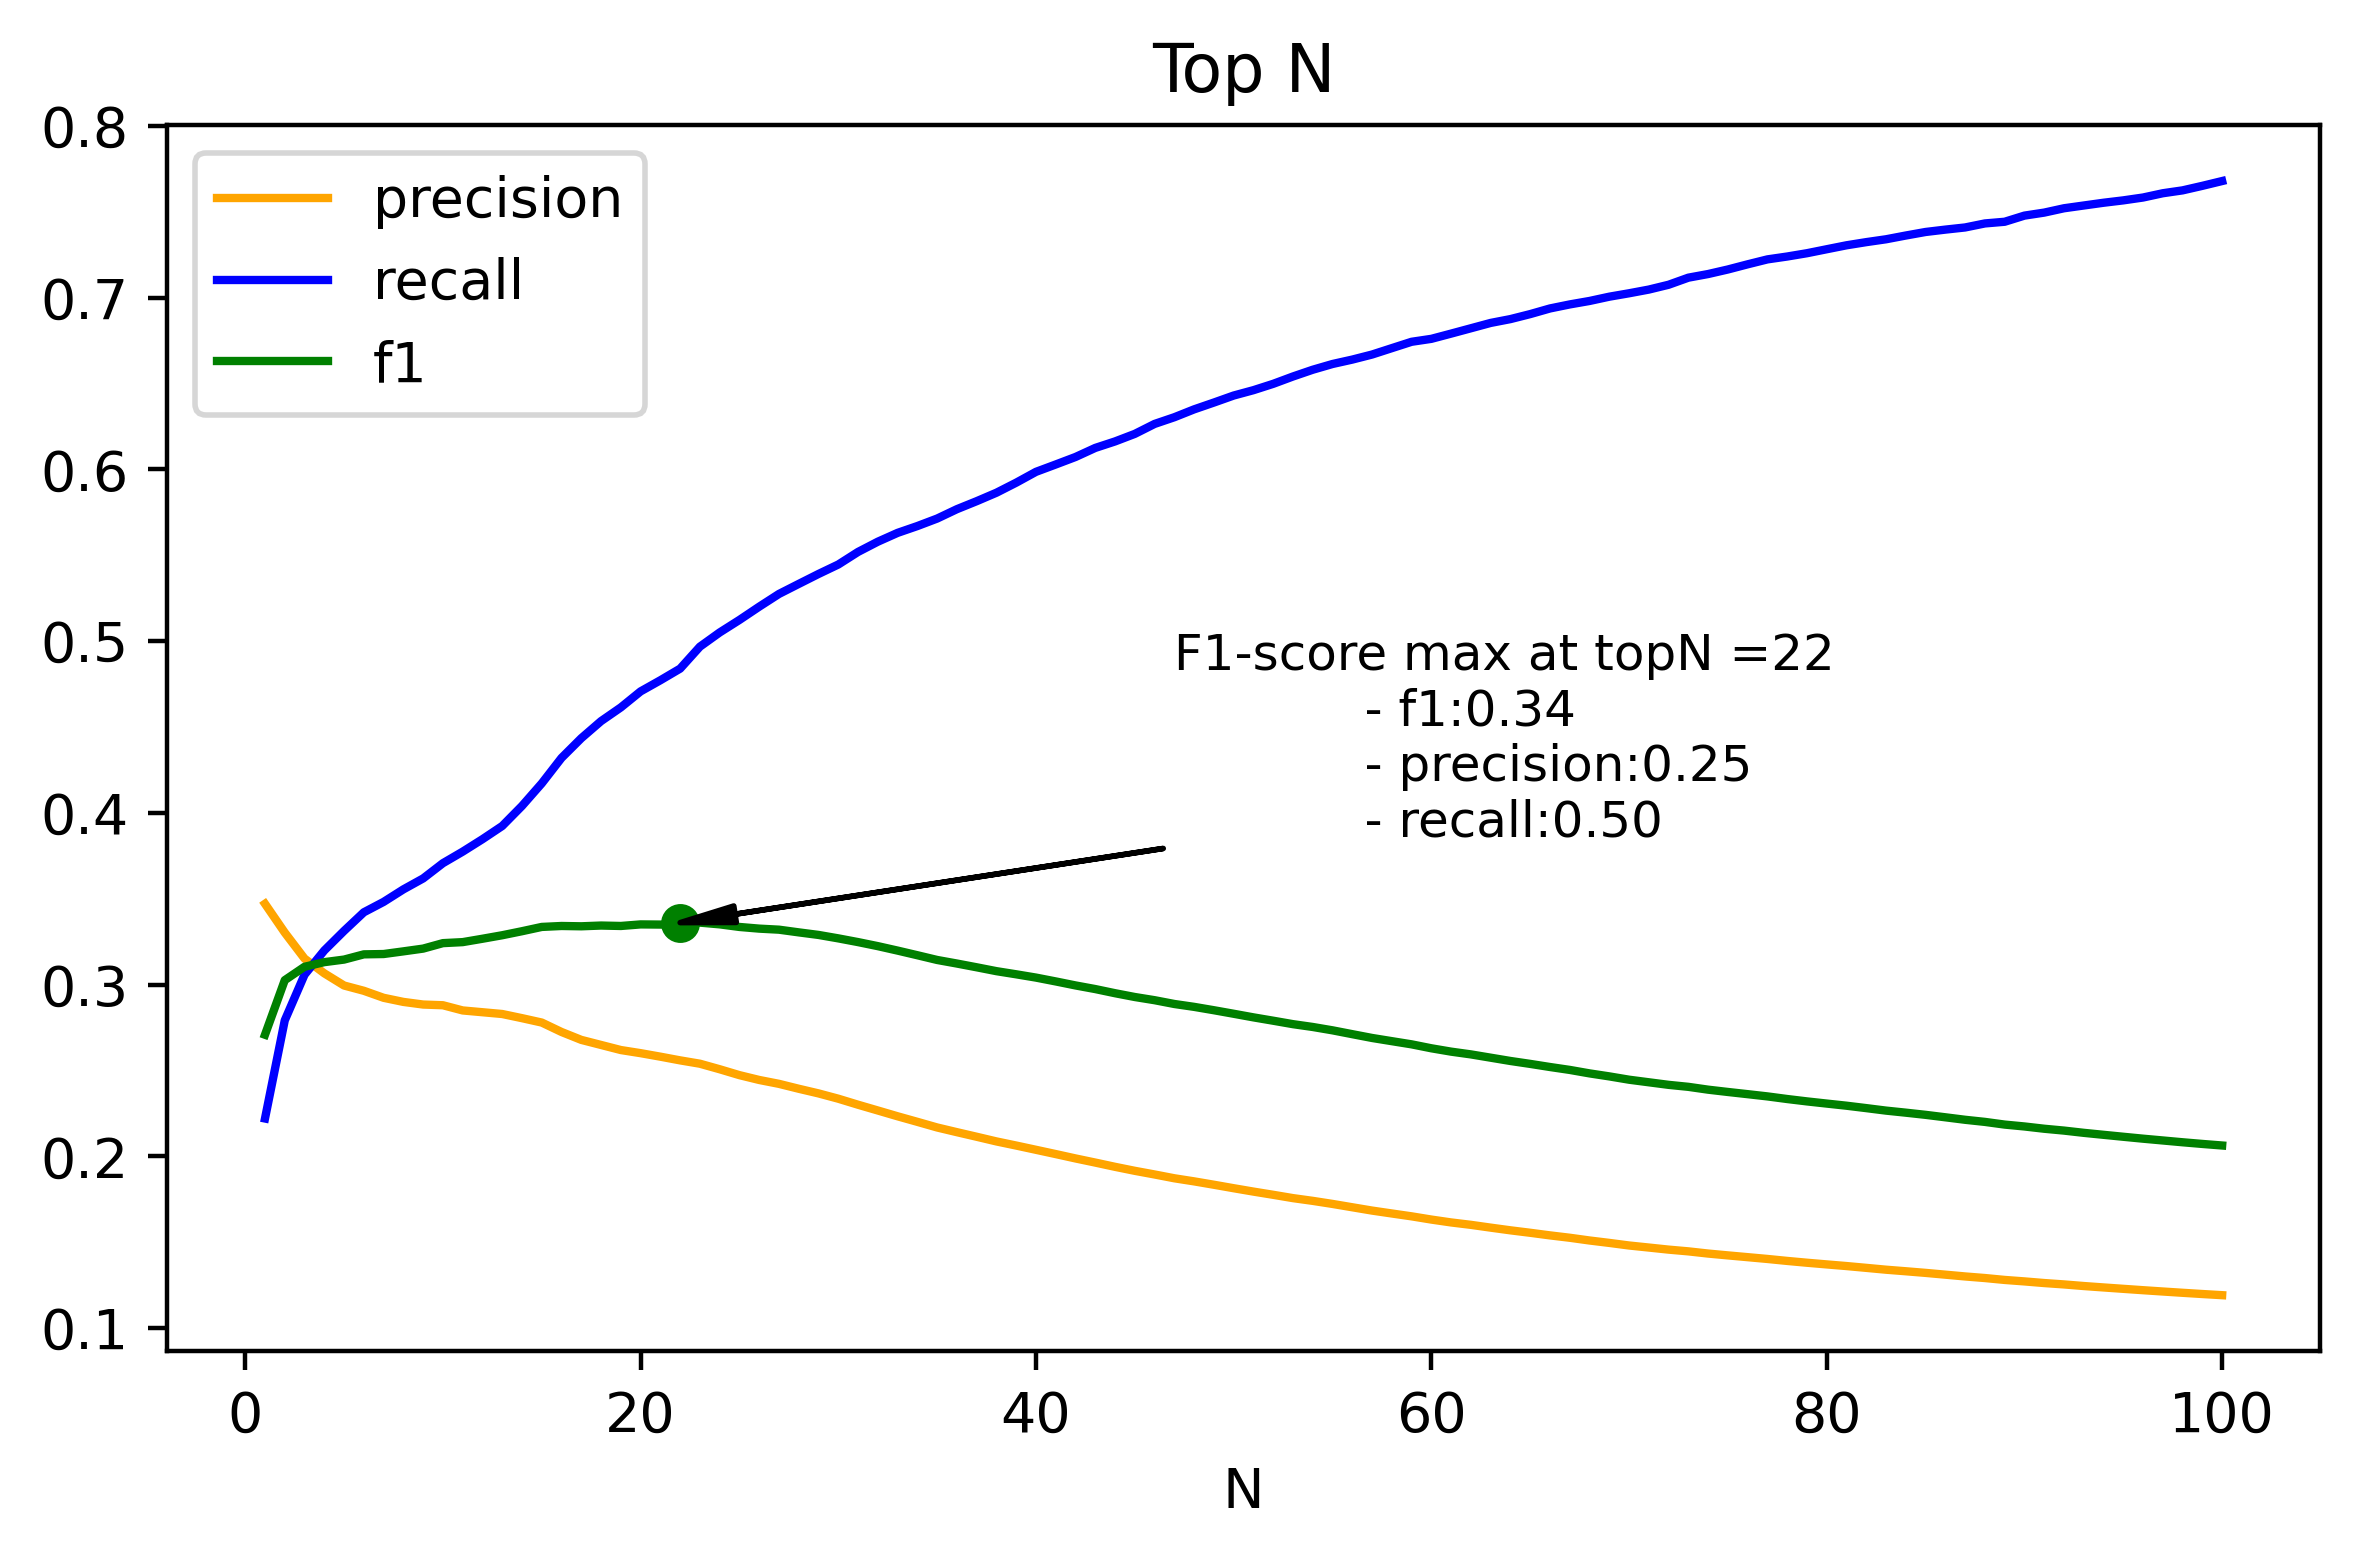

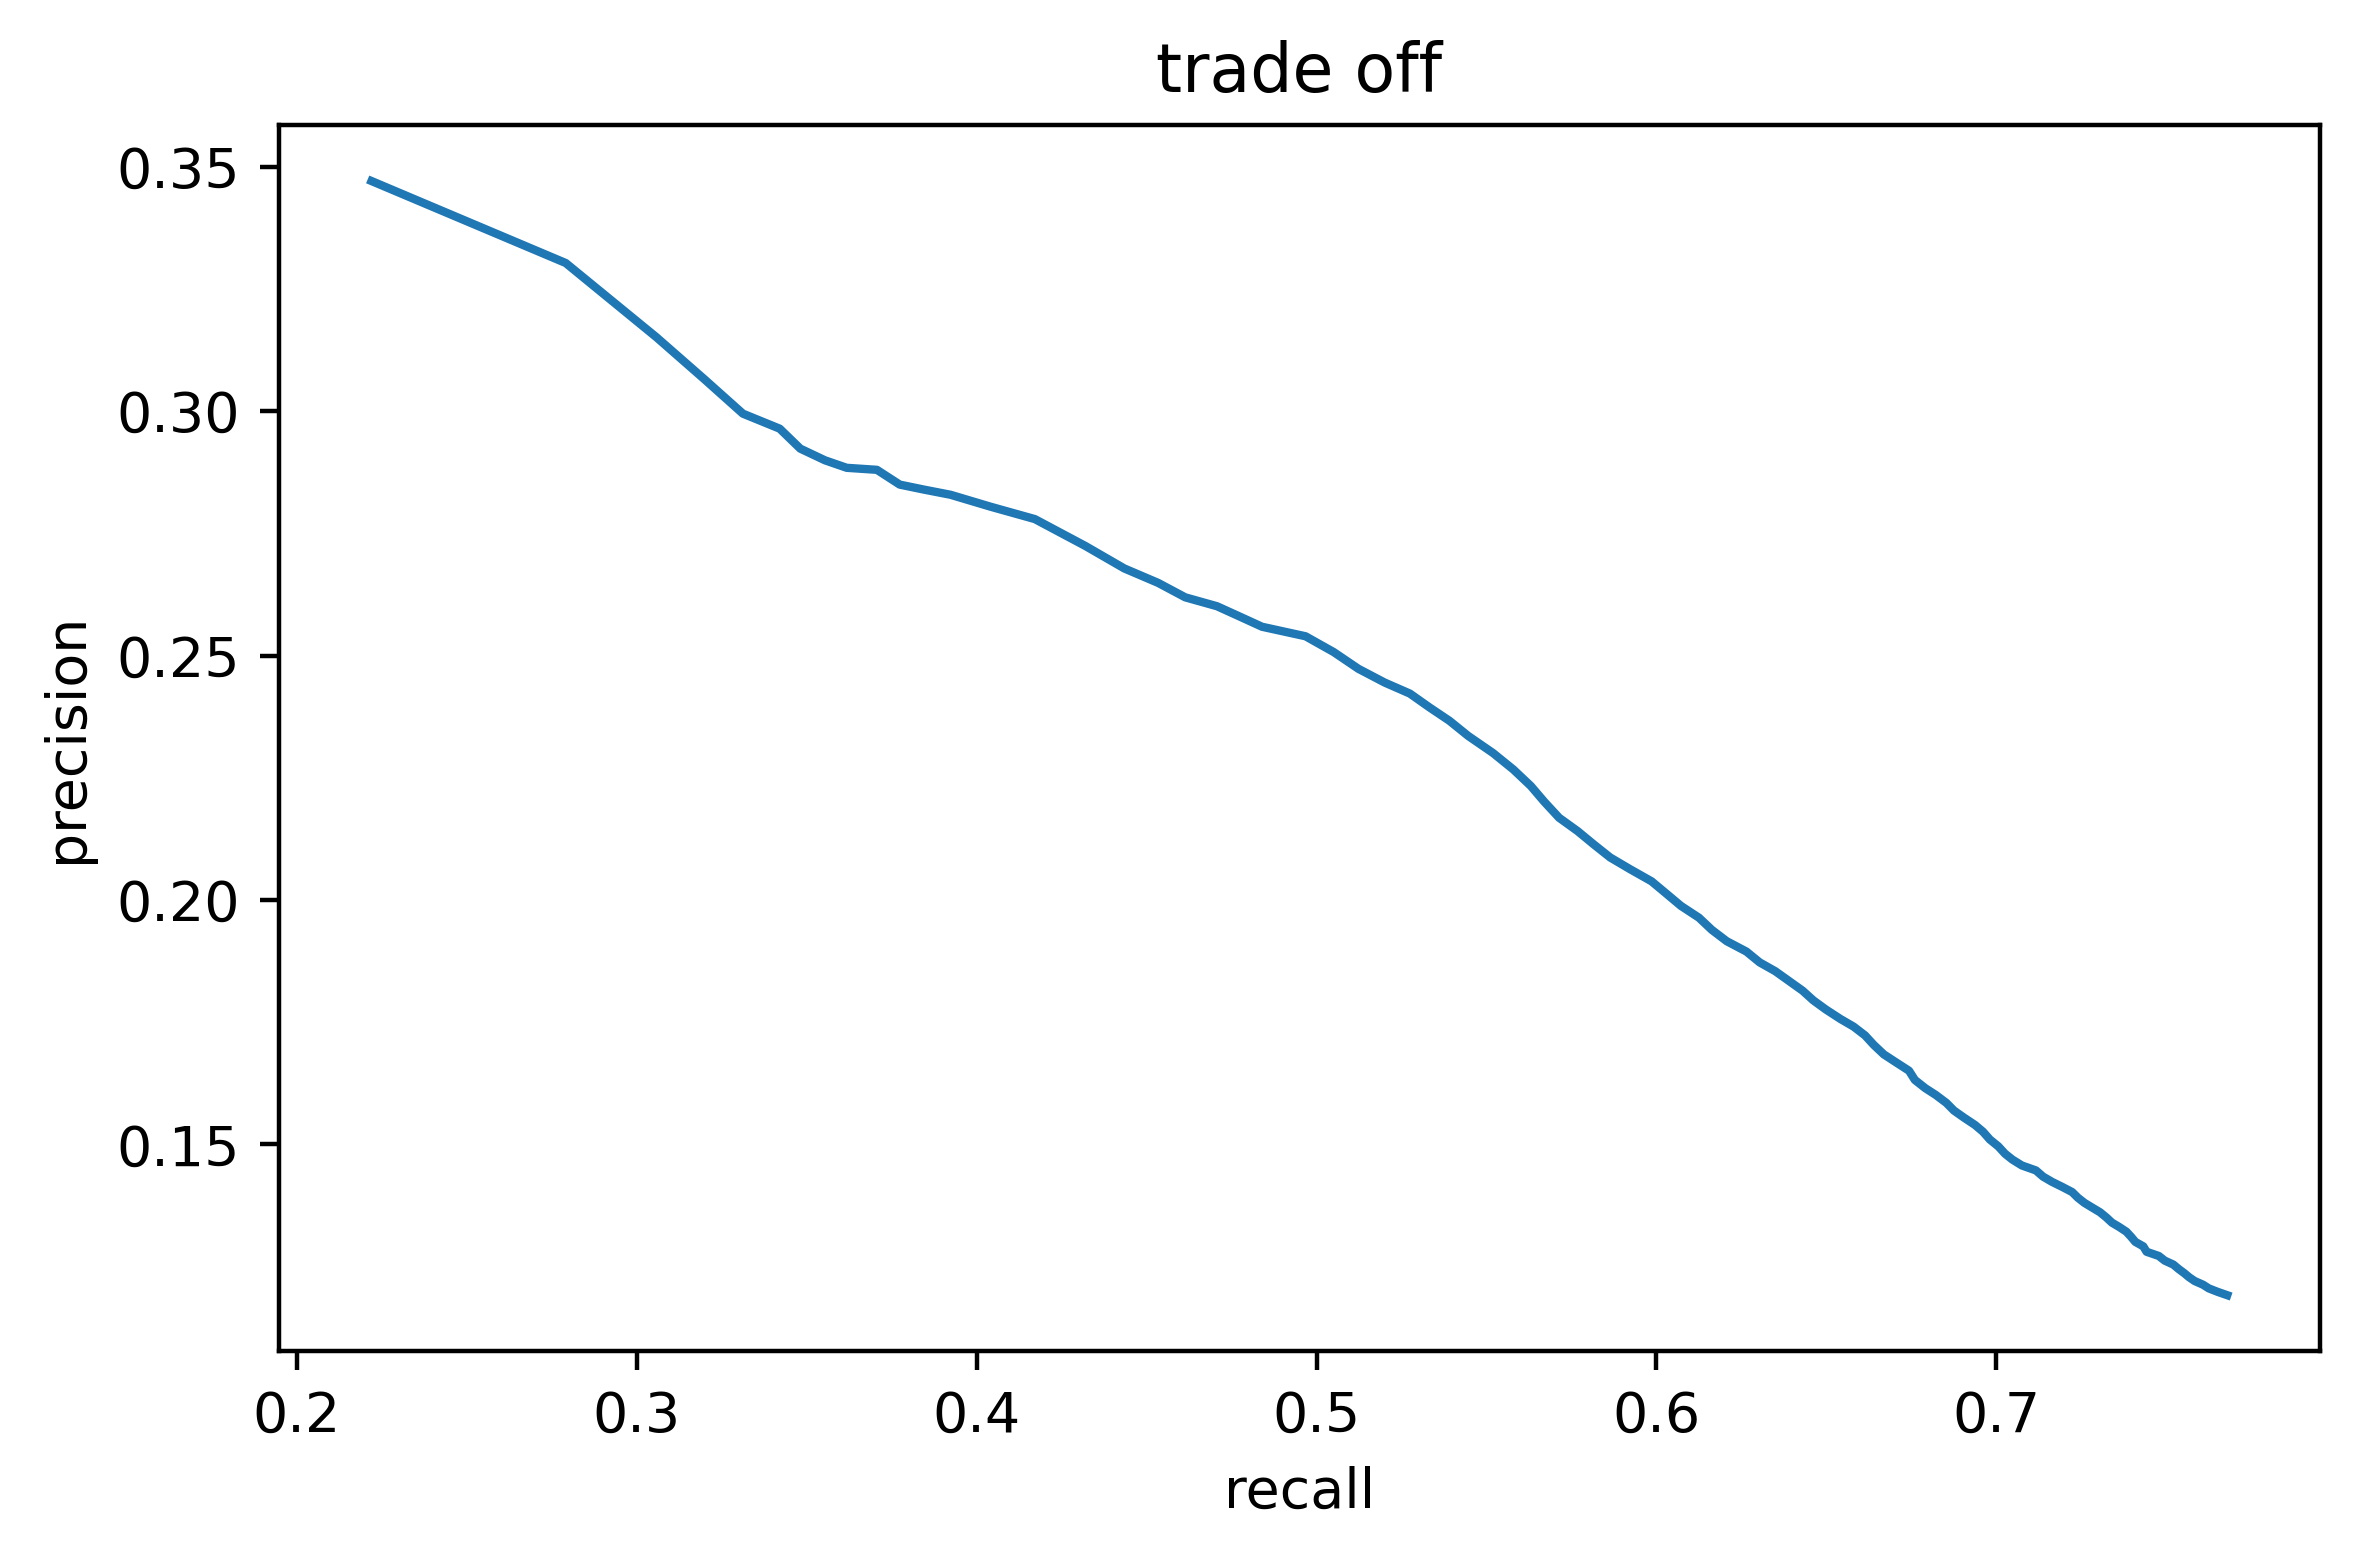

In [58]:
VisualizationKit.plot_cmp_different_n(
    prec=normalization['precision'],
    recall=normalization['recall'],
    f1=normalization['f1']['val'],
    f1_max=normalization['f1']['maxpos'],
    max_topN=100,
    savepath=os.path.join("result","CF","Nor_metrics.jpg")
)


VisualizationKit.precision_recall_tradeoff(
    precision = normalization['precision'], recall = normalization['recall'],
    savepath=os.path.join("result","CF","Nor_Pre_Re.jpg")
)